## For this task, the client has performed some experimentations on some trial stores (77, 86, 88) based on our last research. Let's first find out the eligible control stores out of the other ones and then, compare both trial and control stores to check how the trials went.
    

In [2]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import re
from collections import Counter
import statistics
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Setting parameters for plots
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlelocation'] = 'center'
plt.rcParams['axes.titlepad'] = 20

In [3]:
data = pd.read_csv('QVI_data.csv')

In [4]:
data.head(5)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [6]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [7]:
data.describe()

,LYLTY_CARD_NBR,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,2.648340e+05,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000
mean,1.355488e+05,135.079423,1.351576e+05,56.583554,1.905813,7.299346,182.425512
std,8.057990e+04,76.784063,7.813292e+04,32.826444,0.343436,2.527241,64.325148
min,1.000000e+03,1.000000,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,7.002100e+04,70.000000,6.760050e+04,28.000000,2.000000,5.400000,150.000000
50%,1.303570e+05,130.000000,1.351365e+05,56.000000,2.000000,7.400000,170.000000
75%,2.030940e+05,203.000000,2.026998e+05,85.000000,2.000000,9.200000,175.000000
max,2.373711e+06,272.000000,2.415841e+06,114.000000,5.000000,29.500000,380.000000


### Let's find these measures and filter our control stores, which will be stores that are present throughout the pre-trial period.

- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [8]:
# Creating new month column 
data['YEARMONTH'] = data['DATE'].dt.strftime('%Y%m') 

In [9]:
data.head(3)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903


In [10]:
# For each store and month, calculate total sales, number of customers, transactions per customer, 
# chips per customer and the average price per unit 

measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales = ('TOT_SALES',sum),
    nCustomers = ('LYLTY_CARD_NBR', pd.Series.nunique),
    nAvgTxnPerCust = ('TXN_ID', lambda x: x.count()/data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn = ('PROD_QTY', lambda x: x.sum()/data.loc[x.index, 'TXN_ID'].count()),
    avgPricePerUnit = ('TOT_SALES', lambda x:x.sum()/data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

measure_over_time = measure_over_time.sort_values(by=['STORE_NBR', 'YEARMONTH'])

In [11]:
# Finding stores that worked for full observation period

store_with_full_ob = list((measure_over_time['YEARMONTH'].groupby(measure_over_time['STORE_NBR']).nunique()==12).index)

In [12]:
# Filtering full observation stores in pre-trial period (Feb 2019)

pre_trial_measure = measure_over_time[(measure_over_time['YEARMONTH'] < '201902') & (measure_over_time['STORE_NBR'].isin(store_with_full_ob))]
pre_trial_measure

,STORE_NBR,YEARMONTH,totSales,nCustomers,nAvgTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947
...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,1.125000,1.972222,4.291549
3160,272,201810,430.6,44,1.159091,1.941176,4.349495
3161,272,201811,376.2,41,1.097561,1.933333,4.324138
3162,272,201812,403.9,47,1.000000,1.893617,4.538202


In [13]:
pre_trial_measure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848 entries, 0 to 3163
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        1848 non-null   int64  
 1   YEARMONTH        1848 non-null   object 
 2   totSales         1848 non-null   float64
 3   nCustomers       1848 non-null   int64  
 4   nAvgTxnPerCust   1848 non-null   float64
 5   nChipsPerTxn     1848 non-null   float64
 6   avgPricePerUnit  1848 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 115.5+ KB


In [14]:
# Let's make a function to calculate correlation between control stores and trial/comparison stores

def calculate_correlation(metric_table, metric_col, store_comparison):
    # Creating dataframe for output result
    corr_table = pd.DataFrame(columns = ['store1', 'store2', 'corr_measure'])
    
    # Filtering control stores
    stores = metric_table['STORE_NBR'].unique()
    control_stores = stores[~pd.Series(stores).isin([77, 86, 88])]
    
    for store in control_stores:
        
        # Creating control store data & comparison store data
        compStore_data = metric_table[metric_table['STORE_NBR'] == store_comparison][metric_col].reset_index(drop=True)
        controlStore_data = metric_table[metric_table['STORE_NBR'] == store][metric_col].reset_index(drop=True)
        
        # Checking both stores data have equal length for correlation
        min_len = min(len(compStore_data), len(controlStore_data))
        compStore_data = compStore_data[:min_len]
        controlStore_data = controlStore_data[:min_len]
        
        # Calculating correlation
        corr_measure = compStore_data.corr(controlStore_data)
        
        # Create a DataFrame with the result
        calculated_measure = pd.DataFrame({
            'store1': [store_comparison],
            'store2': [store],
            'corr_measure': [corr_measure]})
        corr_table = pd.concat([corr_table, calculated_measure], ignore_index = True)
        
    # Appending data in output DF
    return corr_table

In [15]:
# Creating a function to calculate a standardised magnitude distance for a measure

def calculate_magnitude_distance(metric_table, metric_col, store_comparison):
    # Creating dataframe for output result
    calc_dist_table = pd.DataFrame(columns = ['store1', 'store2', 'YEARMONTH', 'measure'])
    
    # Getting unique store numbers
    store_numbers = metric_table['STORE_NBR'].unique()

    # Loop through each store number
    for store in store_numbers:
        if store != store_comparison:
            
            # Extracting data for the comparison store and the current control store
            comparison_store_data = metric_table[metric_table['STORE_NBR'] == store_comparison]
            control_store_data = metric_table[metric_table['STORE_NBR'] == store]

            # Merging on YEARMONTH to ensure we are comparing the same months
            merged_data = pd.merge(comparison_store_data, control_store_data, on='YEARMONTH', suffixes=('_comparison', '_control'))

            # Calculating the absolute difference in the metric
            merged_data['measure'] = np.abs(merged_data[f'{metric_col}_comparison'] - merged_data[f'{metric_col}_control'])

            # Creating a DataFrame with the calculated measure
            calculated_measure = merged_data[['STORE_NBR_comparison', 'STORE_NBR_control', 'YEARMONTH', 'measure']]
            calculated_measure.columns = ['store1', 'store2', 'YEARMONTH', 'measure']

            # Appending the result to the calculation table
            calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)
            
    # Standardizing the magnitude distance so that the measure ranges from 0 to 1
    min_max_dist = calc_dist_table.groupby(['store1', 'YEARMONTH']).agg(
        minDist=('measure', 'min'),
        maxDist=('measure', 'max')
    ).reset_index()

    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['store1', 'YEARMONTH'])
    dist_table['magnitude_measure'] = 1 - (dist_table['measure'] - dist_table['minDist']) / (dist_table['maxDist'] - dist_table['minDist'])

    final_dist_table = dist_table.groupby(['store1', 'store2']).agg(
        mag_measure=('magnitude_measure', 'mean')
    ).reset_index()

    return final_dist_table


## Trial Store: 77

In [78]:
# Calculating correlation measure and magnitude distance between trial store & control store sales and customers.

metric_table = pre_trial_measure
trial_store = 77

# Calculate correlations
corr_n_sales = calculate_correlation(metric_table, 'totSales', trial_store)
corr_n_customers = calculate_correlation(metric_table, 'nCustomers', trial_store)

# Calculate magnitude distances
magnitude_n_sales = calculate_magnitude_distance(metric_table, 'totSales', trial_store)
magnitude_n_customers = calculate_magnitude_distance(metric_table, 'nCustomers', trial_store)

# Display the results
print("Correlation of total sales:")
print(corr_n_sales)
print("\nCorrelation of number of customers:")
print(corr_n_customers)
print("\nMagnitude distance of total sales:")
print(magnitude_n_sales)
print("\nMagnitude distance of number of customers:")
print(magnitude_n_customers)

Correlation of total sales:
    store1 store2  corr_measure
0       77      1      0.075218
1       77      2     -0.263079
2       77      3      0.806644
3       77      4     -0.263300
4       77      5     -0.110652
..     ...    ...           ...
263     77    268      0.344757
264     77    269     -0.315730
265     77    270      0.315430
266     77    271      0.355487
267     77    272      0.117622

[268 rows x 3 columns]

Correlation of number of customers:
    store1 store2  corr_measure
0       77      1      0.322168
1       77      2     -0.572051
2       77      3      0.834207
3       77      4     -0.295639
4       77      5      0.370659
..     ...    ...           ...
263     77    268      0.369517
264     77    269     -0.474293
265     77    270     -0.131259
266     77    271      0.019629
267     77    272      0.223217

[268 rows x 3 columns]

Magnitude distance of total sales:
     store1  store2  mag_measure
0        77       1     0.955061
1        77      

In [79]:
# let's merge sales and nCustomers table and assign 0.5 weight of correlation and 0.5 weight of magnitude to give a cumulative rank
weight = 0.5
score_n_sales = pd.merge(corr_n_sales, magnitude_n_sales, on = ['store1', 'store2'])
score_n_sales['score_n_sales'] = weight*(score_n_sales['corr_measure'] + score_n_sales['mag_measure'])

score_n_customers = pd.merge(corr_n_customers, magnitude_n_customers, on = ['store1', 'store2'])
score_n_customers['score_n_customers'] = weight*score_n_customers['corr_measure'] + weight*score_n_customers['mag_measure']

In [80]:
'''Now, let's combine both the scores in a single table and find our control table with highest average score 
of both sales and customer measure scores'''

score_control = pd.merge(score_n_sales[['store1', 'store2', 'score_n_sales']], score_n_customers[['store1', 'store2', 'score_n_customers']], on = ['store1', 'store2']) 
score_control['final_control_score'] = 0.5*score_n_sales['score_n_sales'] + 0.5*score_n_customers['score_n_customers']

score_control.sort_values(by = 'final_control_score', ascending= False).head(5)

,store1,store2,score_n_sales,score_n_customers,final_control_score
228,77,233,0.945433,0.991566,0.968499
40,77,41,0.875075,0.909429,0.892252
16,77,17,0.862491,0.854902,0.858696
249,77,254,0.750788,0.926670,0.838729
110,77,115,0.811868,0.842399,0.827133


#### We can clearly see that store #233 is the most closest to trial store #77. So we can say that store #233 is the control store for store #77

In [81]:
control_store = 233
trial_store = 77

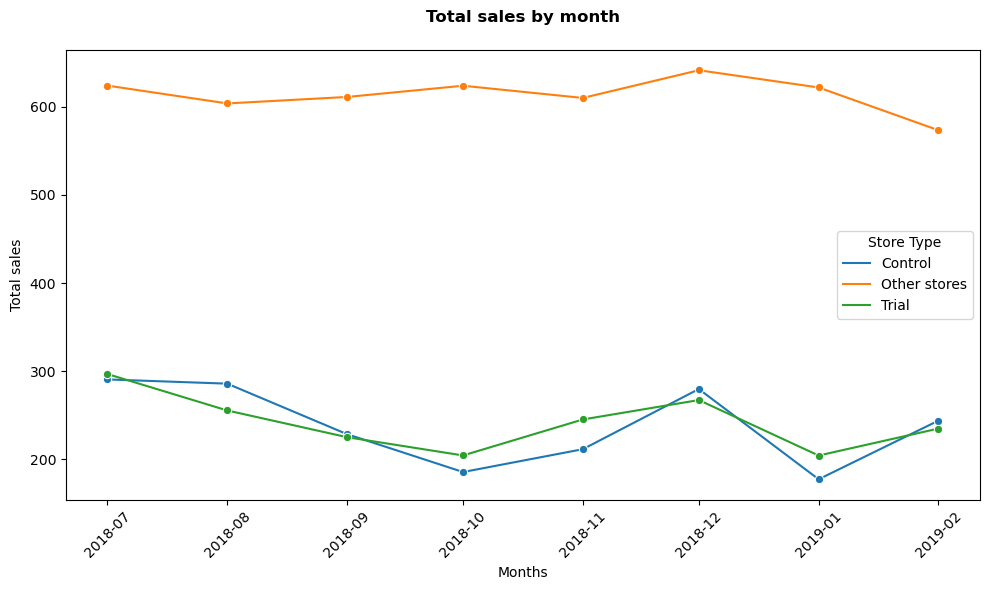

In [82]:
# Let's visualize if the control store was actually similar before trial period

# Categorizing stores
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial', 
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 
                                                    'Control', 
                                                    'Other stores'))

# Calculate mean of totSales by YEARMONTH and Store_type
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

# Convert YEARMONTH to datetime format
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for YEARMONTH < 201903
past_sales = past_sales[past_sales['YEARMONTH'] < '201903']

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.xlabel('Months')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

#### It is clearly visible that sales of both the stores show similar trends over the time.

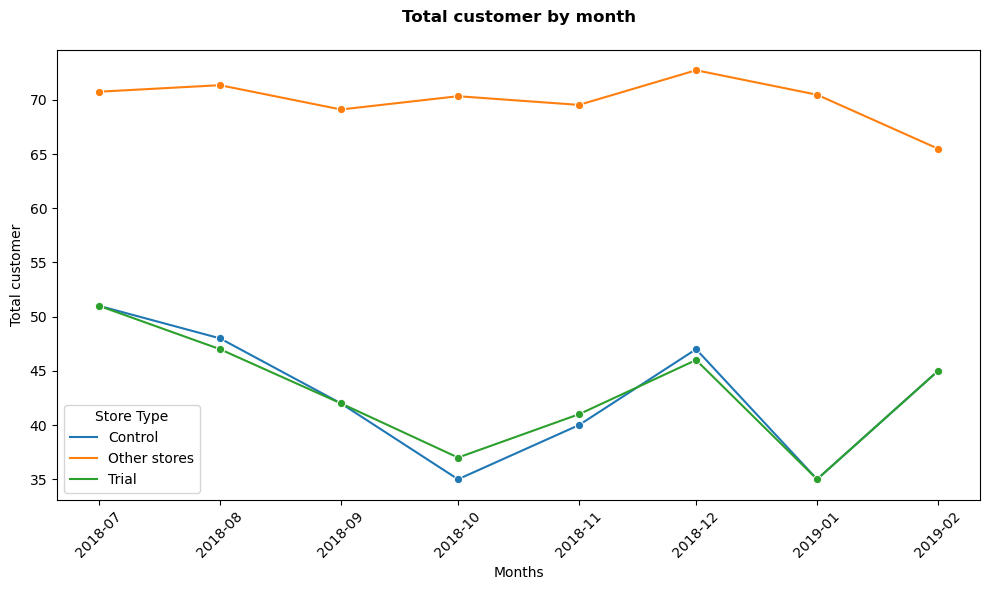

In [83]:
# Let's visualize number of customer trends for both the stores

# Categorizing stores
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial', 
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 
                                                    'Control', 
                                                    'Other stores'))

# Calculate mean of nCustomers by YEARMONTH and Store_type
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()

# Convert YEARMONTH to datetime format
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for YEARMONTH < 201903
past_customers = past_customers[past_customers['YEARMONTH'] < '201903']

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.xlabel('Months')
plt.ylabel('Total customer')
plt.title('Total customer by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()



#### Both of the line charts follow similar trend. Therefore, we can say that our calculation results matches the visualization results.
### Assessment of Trial
#### Trial Period -> start of February 2019 to April 2019

In [84]:
# We now want to see if there has been an uplift in overall chip sales.

# Calculating scaling factor to make control store sales equivalent to trial store sales
scaling_factor_for_control_sales = pre_trial_measure[(pre_trial_measure['STORE_NBR'] == trial_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['totSales'].sum()/pre_trial_measure[(pre_trial_measure['STORE_NBR'] == control_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['totSales'].sum()

# Calculating scaled control sales using scaling factor
scaled_control_sales = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales

# Trial sales
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store].copy()

# Merging trial sales and scaled control sales to find %diff
percentageDiff = pd.merge(trial_sales[['STORE_NBR', 'YEARMONTH', 'totSales']], 
                        scaled_control_sales[['STORE_NBR', 'YEARMONTH','controlSales']],
                       on='YEARMONTH', suffixes=['_trial', '_control'])

percentageDiff['percentDiff'] = (abs(percentageDiff['totSales'] - percentageDiff['controlSales']) / percentageDiff['controlSales'])*100
percentageDiff


,STORE_NBR_trial,YEARMONTH,totSales,STORE_NBR_control,controlSales,percentDiff
0,77,201807,296.8,233,297.565550,0.257271
1,77,201808,255.5,233,292.652187,12.694997
2,77,201809,225.2,233,233.998916,3.760238
3,77,201810,204.5,233,190.085733,7.583035
4,77,201811,245.3,233,216.597421,13.251579
5,77,201812,267.3,233,286.408121,6.671641
6,77,201901,204.4,233,181.692071,12.498029
7,77,201902,235.0,233,249.762622,5.910661
8,77,201903,278.5,233,203.802205,36.652103
9,77,201904,263.5,233,162.345704,62.307960


#### Let's check statistically if there is significant difference between sales of control stores and trial stores in trial period

#### Null Hypothesis: There is no difference between stores and trial stores sales
#### Alternate Hypothesis: There is a significant difference between stores and trial stores sales

In [85]:
# Assuming pre-trial period is equal to trial period.
# Standard deviation calculation for pre-trial period.
std_dev = statistics.stdev(percentageDiff[percentageDiff['YEARMONTH'] < '201902']['percentDiff'])
std_dev

4.994076264142537

In [86]:
# Calculaing t-values based on percentage diff in trial period
trial_percentageDiff = percentageDiff[percentageDiff['YEARMONTH'].isin(['201902','201903','201904'])].copy()
trial_percentageDiff['tValue'] = (trial_percentageDiff['totSales'] - trial_percentageDiff['controlSales'])/std_dev
trial_percentageDiff

,STORE_NBR_trial,YEARMONTH,totSales,STORE_NBR_control,controlSales,percentDiff,tValue
7,77,201902,235.0,233,249.762622,5.910661,-2.956027
8,77,201903,278.5,233,203.802205,36.652103,14.957280
9,77,201904,263.5,233,162.345704,62.307960,20.254856


In [87]:
# Calculating critical value for 95% percentile with degrees of freedom (total months - 1)
critical_value = stats.t.ppf(0.95, 7)
critical_value

1.894578605061305

#### Since t-statistic value is higher than the 95% critical value for the months March & April, we can say that sales of trial stores are significantly higher than the control stores.

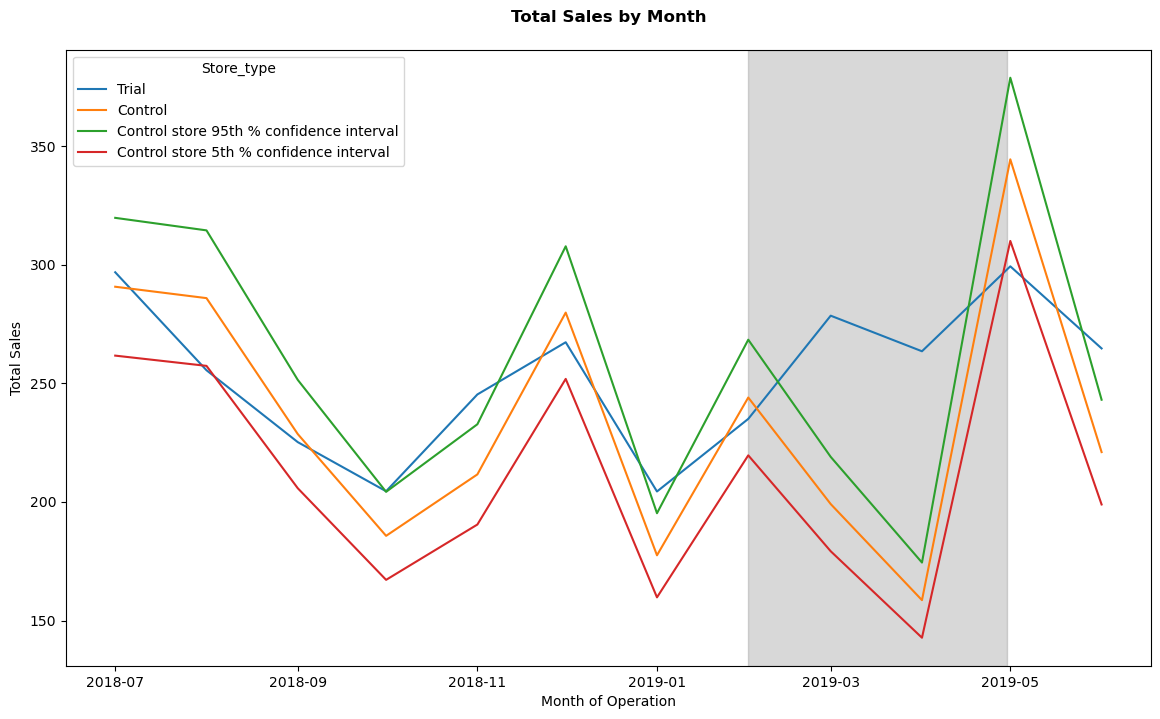

In [88]:
''' Visualizing trial store sales, control store sales, 5% & 95% CI on store sales to check any significant difference 
    in sales of trial and control stores.'''

# Calculate std_dev (standard deviation of percentage difference)
std_dev = std_dev/100

# Prepare data for plotting
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for trial and control stores
past_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([control_store, trial_store])].copy()
past_sales = past_sales.reset_index(drop=True)

# Calculate Control store 95th and 5th percentile
past_sales_controls_95 = past_sales[past_sales['STORE_NBR'] == control_store].copy()
past_sales_controls_95['totSales'] = past_sales_controls_95['totSales'] * (1 + std_dev * 2)
past_sales_controls_95['Store_type'] = 'Control store 95th % confidence interval'
past_sales_controls_95 = past_sales_controls_95.reset_index(drop=True)


past_sales_controls_5 = past_sales[past_sales['STORE_NBR'] == control_store].copy()
past_sales_controls_5['totSales'] = past_sales_controls_5['totSales'] * (1 - std_dev * 2)
past_sales_controls_5['Store_type'] = 'Control store 5th % confidence interval'
past_sales_controls_5 = past_sales_controls_5.reset_index(drop=True)

# Combine all data
trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])
trial_assessment = trial_assessment.reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(dt(2019, 2, 1), dt(2019, 4, 30), color='grey', alpha=0.3, ymin=0, ymax=1)

# Mark significant differences
# Identify months where trial store sales are outside 5% to 95% confidence interval
trial_sales = trial_assessment[trial_assessment['STORE_NBR'] == trial_store]
control_95th = trial_assessment[(trial_assessment['Store_type'] == 'Control store 95th % confidence interval') & 
                                (trial_assessment['STORE_NBR'] == control_store)]
control_5th = trial_assessment[(trial_assessment['Store_type'] == 'Control store 5th % confidence interval') & 
                                (trial_assessment['STORE_NBR'] == control_store)]

# Mark significant points
significant_months = trial_sales[(trial_sales['totSales'] < control_5th['totSales'].min()) | 
                                 (trial_sales['totSales'] > control_95th['totSales'].max())]

plt.scatter(significant_months['TransactionMonth'], significant_months['totSales'], color='red', label='Significant Difference')

plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.show()

#### Let's analyze nCustomers now. We now want to see if there has been an uplift in number of chip customers over trial period.

In [27]:
# Calculating scaling factor to make control store customers equivalent to trial store customers
scaling_factor_for_control_customers = pre_trial_measure[(pre_trial_measure['STORE_NBR'] == trial_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['nCustomers'].sum()/pre_trial_measure[(pre_trial_measure['STORE_NBR'] == control_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['nCustomers'].sum()

# Calculating scaled control customers using scaling factor
scaled_control_customers = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control_customers['controlCustomers'] = scaled_control_customers['nCustomers'] * scaling_factor_for_control_customers

# Trial customers
trial_customers = measure_over_time[measure_over_time['STORE_NBR'] == trial_store].copy()

# Merging trial customers and scaled control customers to find %diff
percentageDiffCust = pd.merge(trial_customers[['STORE_NBR', 'YEARMONTH', 'nCustomers']], 
                        scaled_control_customers[['STORE_NBR', 'YEARMONTH','controlCustomers']],
                       on='YEARMONTH', suffixes=['_trial', '_control'])

percentageDiffCust['percentageDiffCust'] = (abs(percentageDiffCust['nCustomers'] - percentageDiffCust['controlCustomers']) / percentageDiffCust['controlCustomers'])*100
percentageDiffCust

,STORE_NBR_trial,YEARMONTH,nCustomers,STORE_NBR_control,controlCustomers,percentageDiffCust
0,77,201807,51,233,51.171141,0.334448
1,77,201808,47,233,48.161074,2.410814
2,77,201809,42,233,42.140940,0.334448
3,77,201810,37,233,35.117450,5.360726
4,77,201811,41,233,40.134228,2.157191
5,77,201812,46,233,47.157718,2.454992
6,77,201901,35,233,35.117450,0.334448
7,77,201902,45,233,45.151007,0.334448
8,77,201903,50,233,40.134228,24.581940
9,77,201904,47,233,30.100671,56.142698


#### Let's check statistically if there is significant difference between nCustomers of control stores and trial stores in trial period

#### Null Hypothesis: There is no difference between stores and trial stores nCustomers
#### Alternate Hypothesis: There is a significant difference between stores and trial stores nCustomers

In [28]:
# Assuming pre-trial period is equal to trial period.
# Standard deviation calculation for pre-trial period.
std_dev_cust = statistics.stdev(percentageDiffCust[percentageDiffCust['YEARMONTH'] < '201902']['percentageDiffCust'])
std_dev_cust

1.8240748558243947

In [29]:
# Calculaing t-values based on percentage diff in trial period
trial_percentageDiffCust = percentageDiffCust[percentageDiffCust['YEARMONTH'].isin(['201902','201903','201904'])].copy()
trial_percentageDiffCust['tValue'] = (trial_percentageDiffCust['nCustomers'] - trial_percentageDiffCust['controlCustomers'])/std_dev
trial_percentageDiffCust

,STORE_NBR_trial,YEARMONTH,nCustomers,STORE_NBR_control,controlCustomers,percentageDiffCust,tValue
7,77,201902,45,233,45.151007,0.334448,-3.023717
8,77,201903,50,233,40.134228,24.581940,197.549482
9,77,201904,47,233,30.100671,56.142698,338.387481


In [30]:
# Calculating critical value for 95% percentile (1-0.05) with degrees of freedom (total pre-trial months - 1)
critical_value = stats.t.ppf(0.95, 7)
critical_value

1.894578605061305

#### Since t-statistic value is higher than the 95% critical value for the months March & April, we can say that sales of trial stores are significantly higher than the control stores. 

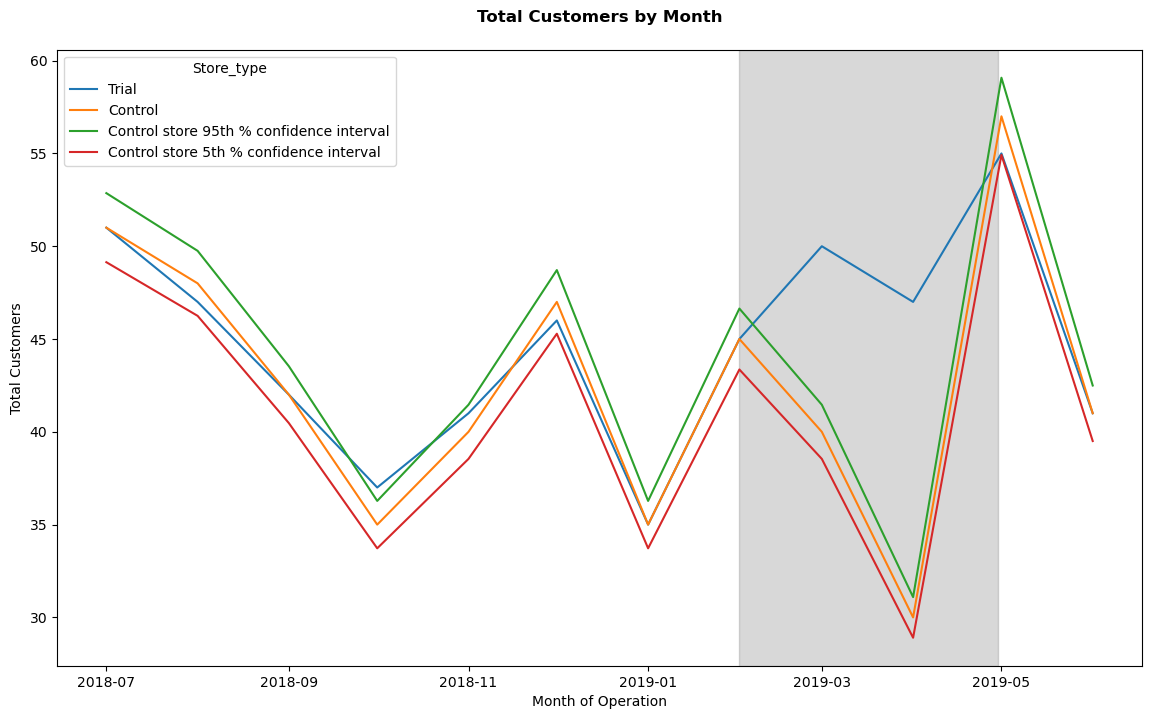

In [31]:
''' Visualizing trial store nCustomers, control store nCustomers, 5% & 95% CI on store nCustomers to check any significant difference 
    in nCustomers of trial and control stores.'''

# Calculate std_dev (standard deviation of percentage difference)
std_dev_cust = std_dev_cust/100

# Prepare data for plotting
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for trial and control stores
past_cust = measure_over_time[measure_over_time['STORE_NBR'].isin([control_store, trial_store])].copy()
past_cust = past_cust.reset_index(drop=True)

# Calculate Control store 95th and 5th percentile
past_cust_controls_95 = past_cust[past_cust['STORE_NBR'] == control_store].copy()
past_cust_controls_95['nCustomers'] = past_cust_controls_95['nCustomers'] * (1 + std_dev_cust * 2)
past_cust_controls_95['Store_type'] = 'Control store 95th % confidence interval'
past_cust_controls_95 = past_cust_controls_95.reset_index(drop=True)


past_cust_controls_5 = past_cust[past_cust['STORE_NBR'] == control_store].copy()
past_cust_controls_5['nCustomers'] = past_cust_controls_5['nCustomers'] * (1 - std_dev_cust * 2)
past_cust_controls_5['Store_type'] = 'Control store 5th % confidence interval'
past_cust_controls_5 = past_cust_controls_5.reset_index(drop=True)

# Combine all data
trial_assessment_cust = pd.concat([past_cust, past_cust_controls_95, past_cust_controls_5])
trial_assessment_cust = trial_assessment_cust.reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=trial_assessment_cust, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(dt(2019, 2, 1), dt(2019, 4, 30), color='grey', alpha=0.3)

# Mark significant differences
# Identify months where trial store sales are outside 5% to 95% confidence interval
trial_sales = trial_assessment_cust[trial_assessment_cust['STORE_NBR'] == trial_store]
control_95th = trial_assessment_cust[(trial_assessment_cust['Store_type'] == 'Control store 95th % confidence interval') & 
                                (trial_assessment_cust['STORE_NBR'] == control_store)]
control_5th = trial_assessment_cust[(trial_assessment_cust['Store_type'] == 'Control store 5th % confidence interval') & 
                                (trial_assessment_cust['STORE_NBR'] == control_store)]

# Mark significant points
significant_months_cust = trial_customers[(trial_customers['nCustomers'] < control_5th['nCustomers'].min()) | 
                                 (trial_customers['nCustomers'] > control_95th['nCustomers'].max())]

plt.scatter(significant_months_cust['TransactionMonth'], significant_months_cust['nCustomers'], color='red', label='Significant Difference')

plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.show()

### The results show that the trial in store 77 is significantly different to its control store 233 in the trial period as the trial store performance of both sales and nCustomers lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

## Trial Store: 86

In [32]:
# Calculating correlation measure and magnitude distance between trial store & control store sales and customers.

metric_table = pre_trial_measure
trial_store = 86

# Calculate correlations
corr_n_sales = calculate_correlation(metric_table, 'totSales', trial_store)
corr_n_customers = calculate_correlation(metric_table, 'nCustomers', trial_store)

# Calculate magnitude distances
magnitude_n_sales = calculate_magnitude_distance(metric_table, 'totSales', trial_store)
magnitude_n_customers = calculate_magnitude_distance(metric_table, 'nCustomers', trial_store)

# Display the results
print("Correlation of total sales:")
print(corr_n_sales)
print("\nCorrelation of number of customers:")
print(corr_n_customers)
print("\nMagnitude distance of total sales:")
print(magnitude_n_sales)
print("\nMagnitude distance of number of customers:")
print(magnitude_n_customers)

Correlation of total sales:
    store1 store2  corr_measure
0       86      1      0.445632
1       86      2     -0.403835
2       86      3     -0.261284
3       86      4     -0.039035
4       86      5      0.235159
..     ...    ...           ...
263     86    268     -0.452182
264     86    269      0.697055
265     86    270     -0.730679
266     86    271      0.527637
267     86    272      0.004926

[268 rows x 3 columns]

Correlation of number of customers:
    store1 store2  corr_measure
0       86      1      0.485831
1       86      2     -0.086161
2       86      3     -0.353786
3       86      4     -0.169608
4       86      5     -0.253229
..     ...    ...           ...
263     86    268     -0.034273
264     86    269     -0.098587
265     86    270     -0.767267
266     86    271      0.267393
267     86    272     -0.353815

[268 rows x 3 columns]

Magnitude distance of total sales:
     store1  store2  mag_measure
0        86       1     0.223241
1        86      

In [33]:
# let's merge sales and nCustomers table and assign 0.5 weight of correlation and 0.5 weight of magnitude to give a cumulative rank
weight = 0.5
score_n_sales = pd.merge(corr_n_sales, magnitude_n_sales, on = ['store1', 'store2'])
score_n_sales['score_n_sales'] = weight*(score_n_sales['corr_measure'] + score_n_sales['mag_measure'])

score_n_customers = pd.merge(corr_n_customers, magnitude_n_customers, on = ['store1', 'store2'])
score_n_customers['score_n_customers'] = weight*score_n_customers['corr_measure'] + weight*score_n_customers['mag_measure']

In [34]:
'''Now, let's combine both the scores in a single table and find our control table with highest average score 
of both sales and customer measure scores'''

score_control = pd.merge(score_n_sales[['store1', 'store2', 'score_n_sales']], score_n_customers[['store1', 'store2', 'score_n_customers']], on = ['store1', 'store2']) 
score_control['final_control_score'] = 0.5*score_n_sales['score_n_sales'] + 0.5*score_n_customers['score_n_customers']

score_control.sort_values(by = 'final_control_score', ascending= False).head(5)

,store1,store2,score_n_sales,score_n_customers,final_control_score
150,86,155,0.921422,0.964021,0.942721
104,86,109,0.876142,0.868499,0.872321
109,86,114,0.827868,0.895696,0.861782
133,86,138,0.842767,0.839141,0.840954
220,86,225,0.787889,0.850679,0.819284


#### We can clearly see that store #155 is the most closest to trial store #86. So we can say that store #155 is the control store for store #86

In [35]:
control_store = 155
trial_store = 86

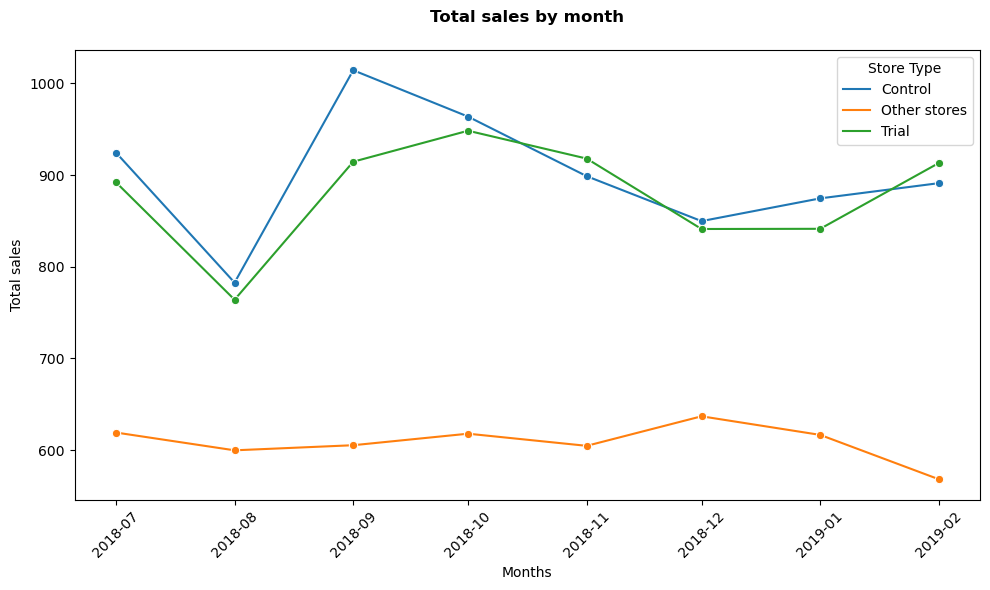

In [36]:
# Let's visualize if the sales of control store and trial store were actually similar before trial period

# Categorizing stores
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial', 
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 
                                                    'Control', 
                                                    'Other stores'))

# Calculate mean of totSales by YEARMONTH and Store_type
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

# Convert YEARMONTH to datetime format
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for YEARMONTH < 201903
past_sales = past_sales[past_sales['YEARMONTH'] < '201903']

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.xlabel('Months')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

#### It is clearly visible that sales of both the stores show similar trends over the time.

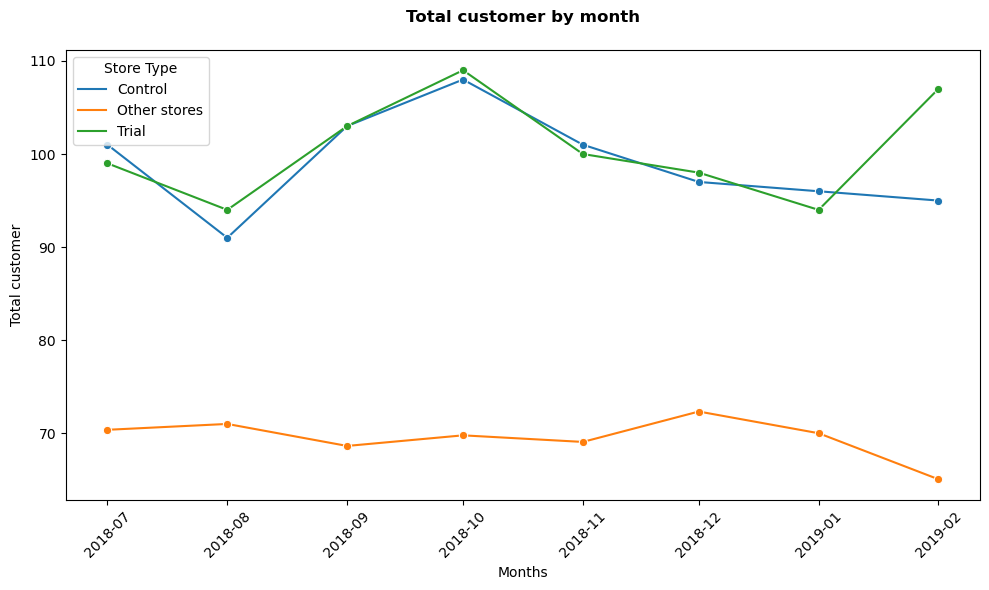

In [37]:
# Let's visualize number of customer trends for both the stores

# Categorizing stores
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial', 
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 
                                                    'Control', 
                                                    'Other stores'))

# Calculate mean of nCustomers by YEARMONTH and Store_type
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()

# Convert YEARMONTH to datetime format
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for YEARMONTH < 201903
past_customers = past_customers[past_customers['YEARMONTH'] < '201903']

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.xlabel('Months')
plt.ylabel('Total customer')
plt.title('Total customer by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()



#### Both of the line charts follow similar trend. Therefore, we can say that the trial store follows the control store trends.
### Assessment of Trial
#### Trial Period -> start of February 2019 to April 2019

In [38]:
# We now want to see if there has been an uplift in overall chip sales.

# Calculating scaling factor to make control store sales equivalent to trial store sales
scaling_factor_for_control_sales = pre_trial_measure[(pre_trial_measure['STORE_NBR'] == trial_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['totSales'].sum()/pre_trial_measure[(pre_trial_measure['STORE_NBR'] == control_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['totSales'].sum()

# Calculating scaled control sales using scaling factor
scaled_control_sales = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales

# Trial sales
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store].copy()

# Merging trial sales and scaled control sales to find %diff
percentageDiff = pd.merge(trial_sales[['STORE_NBR', 'YEARMONTH', 'totSales']], 
                        scaled_control_sales[['STORE_NBR', 'YEARMONTH','controlSales']],
                       on='YEARMONTH', suffixes=['_trial', '_control'])

In [39]:
percentageDiff['percentDiff'] = (abs(percentageDiff['totSales'] - percentageDiff['controlSales']) / percentageDiff['controlSales'])*100
percentageDiff

,STORE_NBR_trial,YEARMONTH,totSales,STORE_NBR_control,controlSales,percentDiff
0,86,201807,892.20,155,896.922236,0.526493
1,86,201808,764.05,155,759.269991,0.629553
2,86,201809,914.60,155,984.034086,7.056065
3,86,201810,948.40,155,934.948790,1.438711
4,86,201811,918.00,155,871.894555,5.287961
5,86,201812,841.20,155,824.361363,2.042628
6,86,201901,841.40,155,848.418979,0.827301
7,86,201902,913.20,155,864.522060,5.630619
8,86,201903,1026.80,155,780.320405,31.586973
9,86,201904,848.20,155,819.317024,3.525250


### Let's check statistically if there is significant difference between sales of control stores and trial stores in trial period

#### Null Hypothesis: There is no difference between stores and trial stores sales
#### Alternate Hypothesis: There is a significant difference between stores and trial stores sales

In [40]:
# Assuming pre-trial period is equal to trial period.
# Standard deviation calculation for pre-trial period.
std_dev = statistics.stdev(percentageDiff[percentageDiff['YEARMONTH'] < '201902']['percentDiff'])
std_dev

2.583395285477237

In [41]:
percentageDiff[percentageDiff['YEARMONTH'].isin(['201902','201903','201904'])]['percentDiff'].std()

15.629167059831852

In [42]:
# Calculaing t-values based on percentage diff in trial period
trial_percentageDiff = percentageDiff[percentageDiff['YEARMONTH'].isin(['201902','201903','201904'])].copy()
trial_percentageDiff['tValue'] = (trial_percentageDiff['totSales'] - trial_percentageDiff['controlSales'])/std_dev
trial_percentageDiff

,STORE_NBR_trial,YEARMONTH,totSales,STORE_NBR_control,controlSales,percentDiff,tValue
7,86,201902,913.2,155,864.522060,5.630619,18.842622
8,86,201903,1026.8,155,780.320405,31.586973,95.409168
9,86,201904,848.2,155,819.317024,3.525250,11.180239


In [43]:
# Calculating critical value for 95% percentile with degrees of freedom (total months - 1)
critical_value = stats.t.ppf(0.95, 7)
critical_value

1.894578605061305

#### Since t-statistic value is higher than the 95% critical value for the months Feb, Mar & Apr, we can say that sales of trial stores are significantly higher than the control stores. Let's verify with visualizing total sales now.

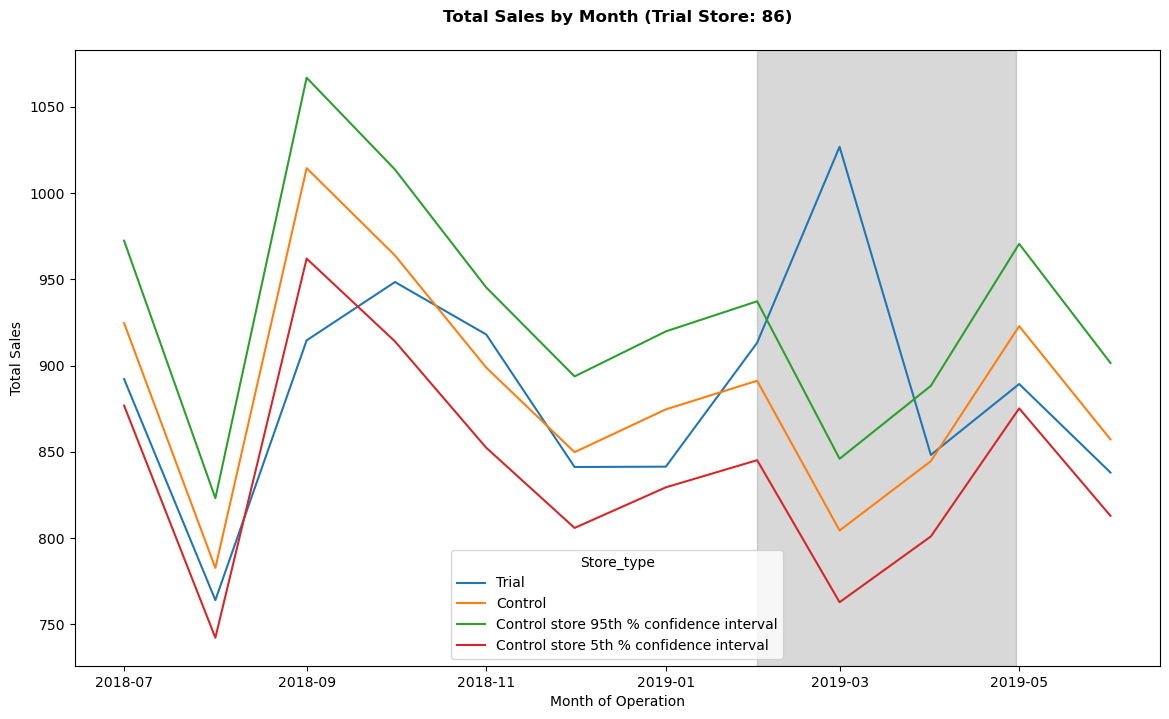

In [44]:
''' Visualizing trial store sales, control store sales, 5% & 95% CI on store sales to check any significant difference 
    in sales of trial and control stores.'''

# Calculate std_dev (standard deviation of percentage difference)
std_dev = std_dev/100

# Prepare data for plotting
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for trial and control stores
past_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([control_store, trial_store])].copy()
past_sales = past_sales.reset_index(drop=True)

# Calculate Control store 95th and 5th percentile
past_sales_controls_95 = past_sales[past_sales['STORE_NBR'] == control_store].copy()
past_sales_controls_95['totSales'] = past_sales_controls_95['totSales'] * (1 + std_dev * 2)
past_sales_controls_95['Store_type'] = 'Control store 95th % confidence interval'
past_sales_controls_95 = past_sales_controls_95.reset_index(drop=True)


past_sales_controls_5 = past_sales[past_sales['STORE_NBR'] == control_store].copy()
past_sales_controls_5['totSales'] = past_sales_controls_5['totSales'] * (1 - std_dev * 2)
past_sales_controls_5['Store_type'] = 'Control store 5th % confidence interval'
past_sales_controls_5 = past_sales_controls_5.reset_index(drop=True)

# Combine all data
trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])
trial_assessment = trial_assessment.reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(dt(2019, 2, 1), dt(2019, 4, 30), color='grey', alpha=0.3, ymin=0, ymax=1)

# Mark significant differences
# Identify months where trial store sales are outside 5% to 95% confidence interval
trial_sales = trial_assessment[trial_assessment['STORE_NBR'] == trial_store]
control_95th = trial_assessment[(trial_assessment['Store_type'] == 'Control store 95th % confidence interval') & 
                                (trial_assessment['STORE_NBR'] == control_store)]
control_5th = trial_assessment[(trial_assessment['Store_type'] == 'Control store 5th % confidence interval') & 
                                (trial_assessment['STORE_NBR'] == control_store)]

# Mark significant points
significant_months = trial_sales[(trial_sales['totSales'] < control_5th['totSales'].min()) | 
                                 (trial_sales['totSales'] > control_95th['totSales'].max())]

plt.scatter(significant_months['TransactionMonth'], significant_months['totSales'], color='red', label='Significant Difference')

plt.title('Total Sales by Month (Trial Store: 86)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.show()

#### Let's analyze nCustomers now. We now want to see if there has been an uplift in number of chip customers over trial period.

In [45]:
# Calculating scaling factor to make control store customers equivalent to trial store customers
scaling_factor_for_control_customers = pre_trial_measure[(pre_trial_measure['STORE_NBR'] == trial_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['nCustomers'].sum()/pre_trial_measure[(pre_trial_measure['STORE_NBR'] == control_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['nCustomers'].sum()

# Calculating scaled control customers using scaling factor
scaled_control_customers = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control_customers['controlCustomers'] = scaled_control_customers['nCustomers'] * scaling_factor_for_control_customers

# Trial customers
trial_customers = measure_over_time[measure_over_time['STORE_NBR'] == trial_store].copy()

# Merging trial customers and scaled control customers to find %diff
percentageDiffCust = pd.merge(trial_customers[['STORE_NBR', 'YEARMONTH', 'nCustomers']], 
                        scaled_control_customers[['STORE_NBR', 'YEARMONTH','controlCustomers']],
                       on='YEARMONTH', suffixes=['_trial', '_control'])

percentageDiffCust['percentageDiffCust'] = ((percentageDiffCust['nCustomers'] - percentageDiffCust['controlCustomers']) / percentageDiffCust['controlCustomers'])*100
percentageDiffCust

,STORE_NBR_trial,YEARMONTH,nCustomers,STORE_NBR_control,controlCustomers,percentageDiffCust
0,86,201807,99,155,101.0,-1.980198
1,86,201808,94,155,91.0,3.296703
2,86,201809,103,155,103.0,0.000000
3,86,201810,109,155,108.0,0.925926
4,86,201811,100,155,101.0,-0.990099
5,86,201812,98,155,97.0,1.030928
6,86,201901,94,155,96.0,-2.083333
7,86,201902,107,155,95.0,12.631579
8,86,201903,115,155,94.0,22.340426
9,86,201904,105,155,99.0,6.060606


#### Let's check statistically if there is significant difference between nCustomers of control stores and trial stores in trial period

#### Null Hypothesis: There is no difference between stores and trial stores nCustomers
#### Alternate Hypothesis: There is a significant difference between stores and trial stores nCustomers

In [46]:
# Assuming pre-trial period is equal to trial period.
# Standard deviation calculation for pre-trial period.
std_dev_cust = statistics.stdev(percentageDiffCust[percentageDiffCust['YEARMONTH'] < '201902']['percentageDiffCust'])
std_dev_cust

1.9159180382211953

In [47]:
# Calculaing t-values based on percentage diff in trial period
trial_percentageDiffCust = percentageDiffCust[percentageDiffCust['YEARMONTH'].isin(['201902','201903','201904'])].copy()
trial_percentageDiffCust['tValue'] = (trial_percentageDiffCust['nCustomers'] - trial_percentageDiffCust['controlCustomers'])/std_dev_cust
trial_percentageDiffCust

,STORE_NBR_trial,YEARMONTH,nCustomers,STORE_NBR_control,controlCustomers,percentageDiffCust,tValue
7,86,201902,107,155,95.0,12.631579,6.263316
8,86,201903,115,155,94.0,22.340426,10.960803
9,86,201904,105,155,99.0,6.060606,3.131658


In [48]:
# Calculating critical value for 95% confidence interval with degrees of freedom (total months - 1)
critical_value = stats.t.ppf(0.95, 7)
critical_value

1.894578605061305

#### Since t-statistic value is higher than the 95% critical value for the months March & April, we can say that sales of trial stores are significantly higher than the control stores. 

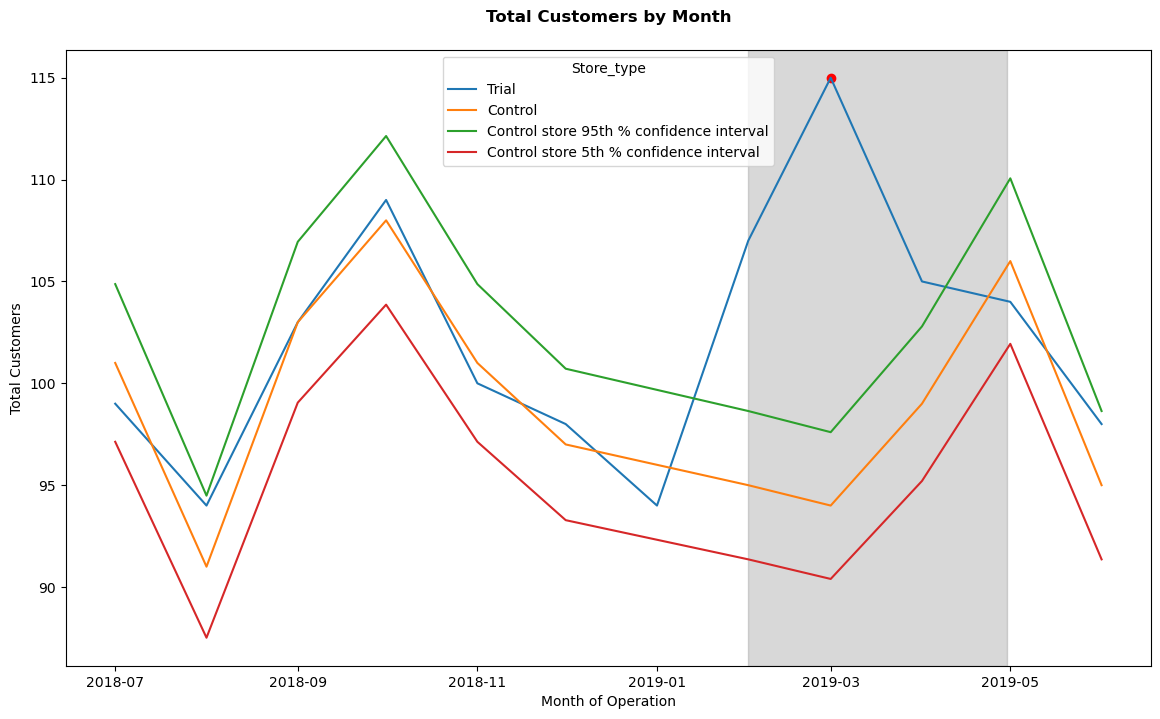

In [49]:
''' Visualizing trial store nCustomers, control store nCustomers, 5% & 95% CI on store nCustomers to check any significant difference 
    in nCustomers of trial and control stores.'''

# Calculate std_dev (standard deviation of percentage difference)
std_dev_cust = std_dev_cust/100

# Prepare data for plotting
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for trial and control stores
past_cust = measure_over_time[measure_over_time['STORE_NBR'].isin([control_store, trial_store])].copy()
past_cust = past_cust.reset_index(drop=True)

# Calculate Control store 95th and 5th percentile
past_cust_controls_95 = past_cust[past_cust['STORE_NBR'] == control_store].copy()
past_cust_controls_95['nCustomers'] = past_cust_controls_95['nCustomers'] * (1 + std_dev_cust * 2)
past_cust_controls_95['Store_type'] = 'Control store 95th % confidence interval'
past_cust_controls_95 = past_cust_controls_95.reset_index(drop=True)


past_cust_controls_5 = past_cust[past_cust['STORE_NBR'] == control_store].copy()
past_cust_controls_5['nCustomers'] = past_cust_controls_5['nCustomers'] * (1 - std_dev_cust * 2)
past_cust_controls_5['Store_type'] = 'Control store 5th % confidence interval'
past_cust_controls_5 = past_cust_controls_5.reset_index(drop=True)

# Combine all data
trial_assessment_cust = pd.concat([past_cust, past_cust_controls_95, past_cust_controls_5])
trial_assessment_cust = trial_assessment_cust.reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=trial_assessment_cust, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(dt(2019, 2, 1), dt(2019, 4, 30), color='grey', alpha=0.3)

# Mark significant differences
# Identify months where trial store sales are outside 5% to 95% confidence interval
trial_sales = trial_assessment_cust[trial_assessment_cust['STORE_NBR'] == trial_store]
control_95th = trial_assessment_cust[(trial_assessment_cust['Store_type'] == 'Control store 95th % confidence interval') & 
                                (trial_assessment_cust['STORE_NBR'] == control_store)]
control_5th = trial_assessment_cust[(trial_assessment_cust['Store_type'] == 'Control store 5th % confidence interval') & 
                                (trial_assessment_cust['STORE_NBR'] == control_store)]

# Mark significant points
significant_months_cust = trial_customers[(trial_customers['nCustomers'] < control_5th['nCustomers'].min()) | 
                                 (trial_customers['nCustomers'] > control_95th['nCustomers'].max())]

plt.scatter(significant_months_cust['TransactionMonth'], significant_months_cust['nCustomers'], color='red', label='Significant Difference')

plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.show()

### The results show that the trial in store 86 is not significantly different to its control store 155 in the trial period as the trial store performance of sales lies inside the 5% to 95% confidence interval of the control store in two of the three trial months. However, we have seen the rise in customers in all the three months of trial period. We need to check with the Category Manager as what led to decline in the total sales.

# Trial Store: 88

In [50]:
metric_table = pre_trial_measure
trial_store = 88

# Calculate correlations
corr_n_sales = calculate_correlation(metric_table, 'totSales', trial_store)
corr_n_customers = calculate_correlation(metric_table, 'nCustomers', trial_store)

# Calculate magnitude distances
magnitude_n_sales = calculate_magnitude_distance(metric_table, 'totSales', trial_store)
magnitude_n_customers = calculate_magnitude_distance(metric_table, 'nCustomers', trial_store)

# Display the results
print("Correlation of total sales:")
print(corr_n_sales)
print("\nCorrelation of number of customers:")
print(corr_n_customers)
print("\nMagnitude distance of total sales:")
print(magnitude_n_sales)
print("\nMagnitude distance of number of customers:")
print(magnitude_n_customers)

Correlation of total sales:
    store1 store2  corr_measure
0       88      1      0.813636
1       88      2     -0.067927
2       88      3     -0.507847
3       88      4     -0.745566
4       88      5      0.190330
..     ...    ...           ...
263     88    268     -0.021429
264     88    269     -0.172578
265     88    270     -0.723272
266     88    271     -0.103037
267     88    272     -0.772772

[268 rows x 3 columns]

Correlation of number of customers:
    store1 store2  corr_measure
0       88      1      0.305334
1       88      2     -0.452379
2       88      3      0.522884
3       88      4     -0.361503
4       88      5     -0.025320
..     ...    ...           ...
263     88    268      0.672672
264     88    269     -0.274781
265     88    270     -0.103032
266     88    271     -0.018831
267     88    272      0.026909

[268 rows x 3 columns]

Magnitude distance of total sales:
     store1  store2  mag_measure
0        88       1     0.145325
1        88      

In [51]:
# let's merge sales and nCustomers table and assign 0.5 weight of correlation and 0.5 weight of magnitude to give a cumulative rank
weight = 0.5
score_n_sales = pd.merge(corr_n_sales, magnitude_n_sales, on = ['store1', 'store2'])
score_n_sales['score_n_sales'] = weight*(score_n_sales['corr_measure'] + score_n_sales['mag_measure'])

score_n_customers = pd.merge(corr_n_customers, magnitude_n_customers, on = ['store1', 'store2'])
score_n_customers['score_n_customers'] = weight*score_n_customers['corr_measure'] + weight*score_n_customers['mag_measure']

In [52]:
'''Now, let's combine both the scores in a single table and find our control table with highest average score 
of both sales and customer measure scores'''

score_control = pd.merge(score_n_sales[['store1', 'store2', 'score_n_sales']], score_n_customers[['store1', 'store2', 'score_n_customers']], on = ['store1', 'store2']) 
score_control['final_control_score'] = 0.5*score_n_sales['score_n_sales'] + 0.5*score_n_customers['score_n_customers']

score_control.sort_values(by = 'final_control_score', ascending= False).head(5)

,store1,store2,score_n_sales,score_n_customers,final_control_score
232,88,237,0.634304,0.970819,0.802562
173,88,178,0.715656,0.883634,0.799645
68,88,69,0.580770,0.845770,0.713270
108,88,113,0.591015,0.826644,0.708830
196,88,201,0.684850,0.719286,0.702068


#### We can clearly see that store #237 is the most closest to trial store #88. So we can say that store #237 is the control store for trial store #88

In [53]:
control_store = 237
trial_store = 88

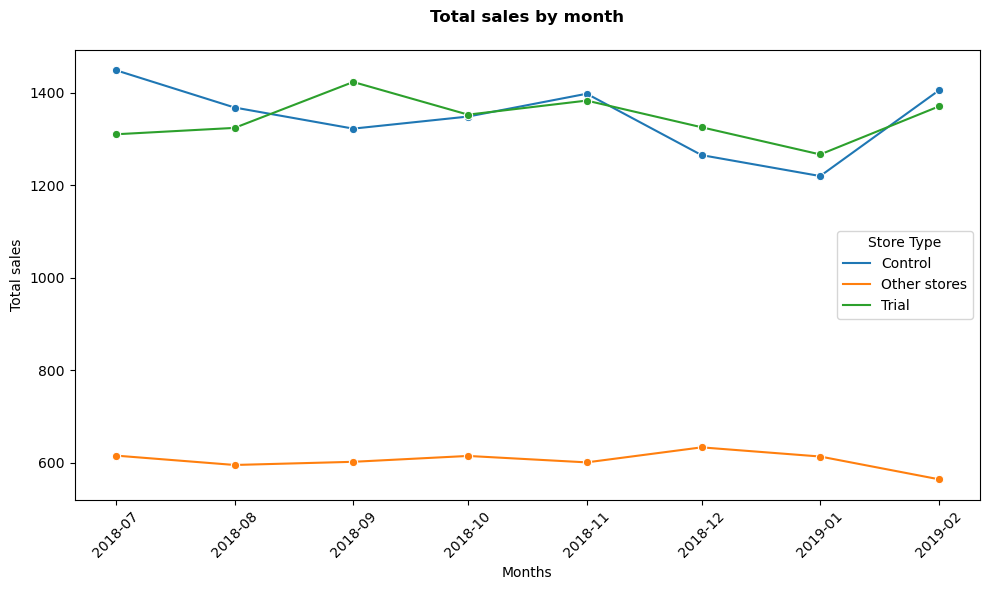

In [54]:
# Let's visualize if the sales of control store and trial store were actually similar before trial period

# Categorizing stores
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial', 
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 
                                                    'Control', 
                                                    'Other stores'))

# Calculate mean of totSales by YEARMONTH and Store_type
past_sales = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg({'totSales': 'mean'}).reset_index()

# Convert YEARMONTH to datetime format
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for YEARMONTH < 201903
past_sales = past_sales[past_sales['YEARMONTH'] < '201903']

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', marker='o')
plt.xlabel('Months')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

#### It can be argued that the overall sales trends of both stores are similar, even though there is a slight divergence at the beginning.

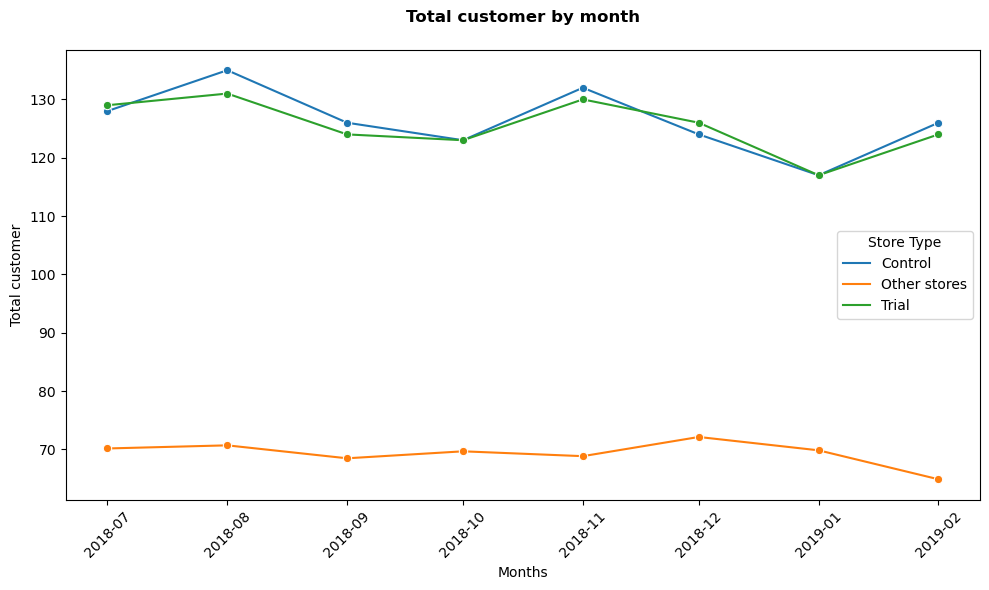

In [55]:
# Let's visualize number of customer trends for both the stores

# Categorizing stores
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial', 
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 
                                                    'Control', 
                                                    'Other stores'))

# Calculate mean of nCustomers by YEARMONTH and Store_type
past_customers = measure_over_time.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()

# Convert YEARMONTH to datetime format
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for YEARMONTH < 201903
past_customers = past_customers[past_customers['YEARMONTH'] < '201903']

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='nCustomers', hue='Store_type', marker='o')
plt.xlabel('Months')
plt.ylabel('Total customer')
plt.title('Total customer by month')
plt.xticks(rotation=45)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()


#### Both of the line charts follow similar trend. Therefore, we can say that our number of customers for trial stores follows trend of control stores over the time.
### Assessment of Trial
#### Trial Period -> start of February 2019 to April 2019

In [56]:
# We now want to see if there has been an uplift in overall chip sales.

# Calculating scaling factor to make control store sales equivalent to trial store sales
scaling_factor_for_control_sales = pre_trial_measure[(pre_trial_measure['STORE_NBR'] == trial_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['totSales'].sum()/pre_trial_measure[(pre_trial_measure['STORE_NBR'] == control_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['totSales'].sum()

# Calculating scaled control sales using scaling factor
scaled_control_sales = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control_sales['controlSales'] = scaled_control_sales['totSales'] * scaling_factor_for_control_sales

# Trial sales
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store].copy()

# Merging trial sales and scaled control sales to find %diff
percentageDiff = pd.merge(trial_sales[['STORE_NBR', 'YEARMONTH', 'totSales']], 
                        scaled_control_sales[['STORE_NBR', 'YEARMONTH','controlSales']],
                       on='YEARMONTH', suffixes=['_trial', '_control'])

percentageDiff['percentDiff'] = ((percentageDiff['totSales'] - percentageDiff['controlSales']) / percentageDiff['controlSales'])*100
percentageDiff


,STORE_NBR_trial,YEARMONTH,totSales,STORE_NBR_control,controlSales,percentDiff
0,88,201807,1310.00,237,1450.657086,-9.696095
1,88,201808,1323.80,237,1369.931485,-3.367430
2,88,201809,1423.00,237,1324.260425,7.456205
3,88,201810,1352.40,237,1350.401097,0.148023
4,88,201811,1382.80,237,1399.777923,-1.212901
5,88,201812,1325.20,237,1266.971288,4.595898
6,88,201901,1266.40,237,1221.600696,3.667262
7,88,201902,1370.20,237,1406.989143,-2.614742
8,88,201903,1477.20,237,1210.082775,22.074294
9,88,201904,1439.40,237,1206.477165,19.306029


### Let's check statistically if there is significant difference between sales of control stores and trial stores in trial period

#### Null Hypothesis: There is no difference between stores and trial stores sales
#### Alternate Hypothesis: There is a significant difference between stores and trial stores sales 

In [57]:
# Assuming pre-trial period is equal to trial period.
# Standard deviation calculation for pre-trial period.
std_dev = statistics.stdev(percentageDiff[percentageDiff['YEARMONTH'] < '201902']['percentDiff'])
std_dev

5.724965451900226

In [58]:
# Calculaing t-values based on percentage diff in trial period
trial_percentageDiff = percentageDiff[percentageDiff['YEARMONTH'].isin(['201902','201903','201904'])].copy()
trial_percentageDiff['tValue'] = (trial_percentageDiff['totSales'] - trial_percentageDiff['controlSales'])/std_dev
trial_percentageDiff

,STORE_NBR_trial,YEARMONTH,totSales,STORE_NBR_control,controlSales,percentDiff,tValue
7,88,201902,1370.2,237,1406.989143,-2.614742,-6.426090
8,88,201903,1477.2,237,1210.082775,22.074294,46.658312
9,88,201904,1439.4,237,1206.477165,19.306029,40.685457


In [59]:
# Calculating critical value for 95% confidence interval with degrees of freedom (total months - 1) in trial period
critical_value = stats.t.ppf(0.95, 2)
critical_value

2.919985580355516

#### Since t-statistic value is higher than the 95% critical value for the months March & April, we can say that sales of trial stores are significantly higher than the control stores.

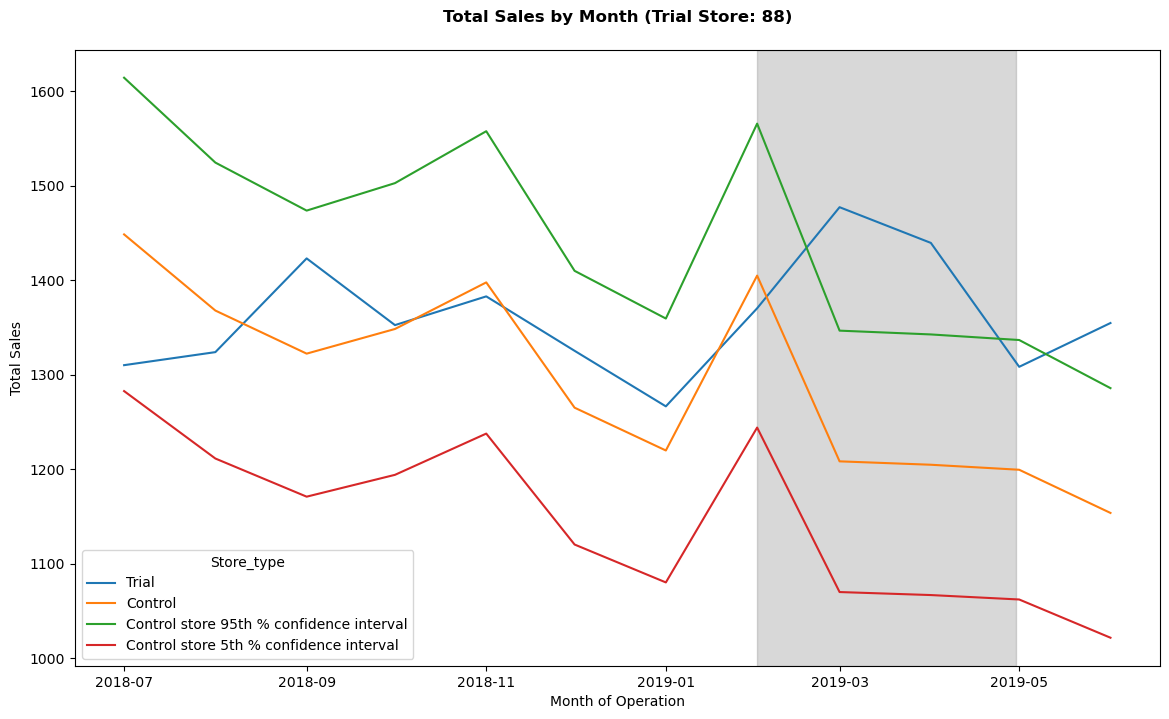

In [60]:
''' Visualizing trial store sales, control store sales, 5% & 95% CI on store sales to check any significant difference 
    in sales of trial and control stores.'''

# Calculate std_dev (standard deviation of percentage difference)
std_dev = std_dev/100

# Prepare data for plotting
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for trial and control stores
past_sales = measure_over_time[measure_over_time['STORE_NBR'].isin([control_store, trial_store])].copy()
past_sales = past_sales.reset_index(drop=True)

# Calculate Control store 95th and 5th percentile
past_sales_controls_95 = past_sales[past_sales['STORE_NBR'] == control_store].copy()
past_sales_controls_95['totSales'] = past_sales_controls_95['totSales'] * (1 + std_dev * 2)
past_sales_controls_95['Store_type'] = 'Control store 95th % confidence interval'
past_sales_controls_95 = past_sales_controls_95.reset_index(drop=True)


past_sales_controls_5 = past_sales[past_sales['STORE_NBR'] == control_store].copy()
past_sales_controls_5['totSales'] = past_sales_controls_5['totSales'] * (1 - std_dev * 2)
past_sales_controls_5['Store_type'] = 'Control store 5th % confidence interval'
past_sales_controls_5 = past_sales_controls_5.reset_index(drop=True)

# Combine all data
trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])
trial_assessment = trial_assessment.reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type')

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(dt(2019, 2, 1), dt(2019, 4, 30), color='grey', alpha=0.3, ymin=0, ymax=1)

# Mark significant differences
# Identify months where trial store sales are outside 5% to 95% confidence interval
trial_sales = trial_assessment[trial_assessment['STORE_NBR'] == trial_store]
control_95th = trial_assessment[(trial_assessment['Store_type'] == 'Control store 95th % confidence interval') & 
                                (trial_assessment['STORE_NBR'] == control_store)]
control_5th = trial_assessment[(trial_assessment['Store_type'] == 'Control store 5th % confidence interval') & 
                                (trial_assessment['STORE_NBR'] == control_store)]

# Mark significant points
significant_months = trial_sales[(trial_sales['totSales'] < control_5th['totSales'].min()) | 
                                 (trial_sales['totSales'] > control_95th['totSales'].max())]

plt.scatter(significant_months['TransactionMonth'], significant_months['totSales'], color='red', label='Significant Difference')

plt.title('Total Sales by Month (Trial Store: 88)')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.show()

#### Let's analyze nCustomers now. We now want to see if there has been an uplift in number of chip customers over trial period. 

In [61]:
# Calculating scaling factor to make control store customers equivalent to trial store customers
scaling_factor_for_control_customers = pre_trial_measure[(pre_trial_measure['STORE_NBR'] == trial_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['nCustomers'].sum()/pre_trial_measure[(pre_trial_measure['STORE_NBR'] == control_store) & 
(pre_trial_measure['YEARMONTH'] < '201902')]['nCustomers'].sum()

# Calculating scaled control customers using scaling factor
scaled_control_customers = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control_customers['controlCustomers'] = scaled_control_customers['nCustomers'] * scaling_factor_for_control_customers

# Trial customers
trial_customers = measure_over_time[measure_over_time['STORE_NBR'] == trial_store].copy()

# Merging trial customers and scaled control customers to find %diff
percentageDiffCust = pd.merge(trial_customers[['STORE_NBR', 'YEARMONTH', 'nCustomers']], 
                        scaled_control_customers[['STORE_NBR', 'YEARMONTH','controlCustomers']],
                       on='YEARMONTH', suffixes=['_trial', '_control'])

percentageDiffCust['percentageDiffCust'] = ((percentageDiffCust['nCustomers'] - percentageDiffCust['controlCustomers']) / percentageDiffCust['controlCustomers'])*100
percentageDiffCust

,STORE_NBR_trial,YEARMONTH,nCustomers,STORE_NBR_control,controlCustomers,percentageDiffCust
0,88,201807,129,237,127.276836,1.353871
1,88,201808,131,237,134.237288,-2.411616
2,88,201809,124,237,125.288136,-1.028139
3,88,201810,123,237,122.305085,0.568182
4,88,201811,130,237,131.254237,-0.955579
5,88,201812,126,237,123.299435,2.190249
6,88,201901,117,237,116.338983,0.568182
7,88,201902,124,237,125.288136,-1.028139
8,88,201903,134,237,118.327684,13.244843
9,88,201904,128,237,119.322034,7.272727


#### Let's check statistically if there is significant difference between nCustomers of control stores and trial stores in trial period

#### Null Hypothesis: There is no difference between stores and trial stores nCustomers
#### Alternate Hypothesis: There is a significant difference between stores and trial stores nCustomers

In [62]:
# Assuming pre-trial period is equal to trial period.
# Standard deviation calculation for pre-trial period.
std_dev_cust = statistics.stdev(percentageDiffCust[percentageDiffCust['YEARMONTH'] < '201902']['percentageDiffCust'])
std_dev_cust

1.5837873803830578

In [63]:
# Calculaing t-values based on percentage diff in trial period
trial_percentageDiffCust = percentageDiffCust[percentageDiffCust['YEARMONTH'].isin(['201902','201903','201904'])].copy()
trial_percentageDiffCust['tValue'] = (trial_percentageDiffCust['nCustomers'] - trial_percentageDiffCust['controlCustomers'])/std_dev_cust
trial_percentageDiffCust

,STORE_NBR_trial,YEARMONTH,nCustomers,STORE_NBR_control,controlCustomers,percentageDiffCust,tValue
7,88,201902,124,237,125.288136,-1.028139,-0.813326
8,88,201903,134,237,118.327684,13.244843,9.895467
9,88,201904,128,237,119.322034,7.272727,5.479249


In [64]:
# Calculating critical value for 95% confidence interval with degrees of freedom (total months - 1)
critical_value = stats.t.ppf(0.95, 7)
critical_value

1.894578605061305

#### Since t-statistic value is higher than the 95% critical value for the months March & April, we can say that sales of trial stores are significantly higher than the control stores.  

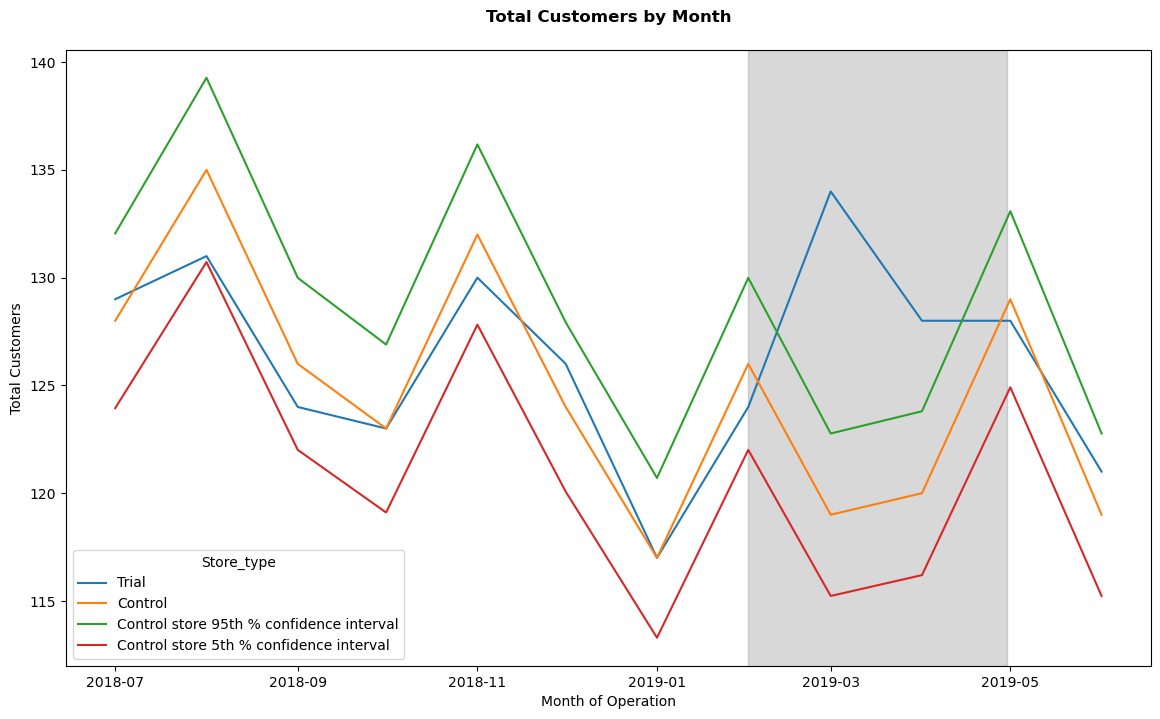

In [65]:
''' Visualizing trial store nCustomers, control store nCustomers, 5% & 95% CI on store nCustomers to check any significant difference 
    in nCustomers of trial and control stores.'''

# Calculate std_dev (standard deviation of percentage difference)
std_dev_cust = std_dev_cust/100

# Prepare data for plotting
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str) + '01', format='%Y%m%d')

# Filter data for trial and control stores
past_cust = measure_over_time[measure_over_time['STORE_NBR'].isin([control_store, trial_store])].copy()
past_cust = past_cust.reset_index(drop=True)

# Calculate Control store 95th and 5th percentile
past_cust_controls_95 = past_cust[past_cust['STORE_NBR'] == control_store].copy()
past_cust_controls_95['nCustomers'] = past_cust_controls_95['nCustomers'] * (1 + std_dev_cust * 2)
past_cust_controls_95['Store_type'] = 'Control store 95th % confidence interval'
past_cust_controls_95 = past_cust_controls_95.reset_index(drop=True)


past_cust_controls_5 = past_cust[past_cust['STORE_NBR'] == control_store].copy()
past_cust_controls_5['nCustomers'] = past_cust_controls_5['nCustomers'] * (1 - std_dev_cust * 2)
past_cust_controls_5['Store_type'] = 'Control store 5th % confidence interval'
past_cust_controls_5 = past_cust_controls_5.reset_index(drop=True)

# Combine all data
trial_assessment_cust = pd.concat([past_cust, past_cust_controls_95, past_cust_controls_5])
trial_assessment_cust = trial_assessment_cust.reset_index(drop=True)

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(data=trial_assessment_cust, x='TransactionMonth', y='nCustomers', hue='Store_type')

# Highlight the trial period (Feb 2019 to Apr 2019)
plt.axvspan(dt(2019, 2, 1), dt(2019, 4, 30), color='grey', alpha=0.3)

# Mark significant differences
# Identify months where trial store sales are outside 5% to 95% confidence interval
trial_sales = trial_assessment_cust[trial_assessment_cust['STORE_NBR'] == trial_store]
control_95th = trial_assessment_cust[(trial_assessment_cust['Store_type'] == 'Control store 95th % confidence interval') & 
                                (trial_assessment_cust['STORE_NBR'] == control_store)]
control_5th = trial_assessment_cust[(trial_assessment_cust['Store_type'] == 'Control store 5th % confidence interval') & 
                                (trial_assessment_cust['STORE_NBR'] == control_store)]

# Mark significant points
significant_months_cust = trial_customers[(trial_customers['nCustomers'] < control_5th['nCustomers'].min()) | 
                                 (trial_customers['nCustomers'] > control_95th['nCustomers'].max())]

plt.scatter(significant_months_cust['TransactionMonth'], significant_months_cust['nCustomers'], color='red', label='Significant Difference')

plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Customers')
plt.show()

#### The results show that the trial in store 88 is significantly different to its control store 237 in the trial period as the trial store performance of both sales and nCustomers lies outside the 5% to 95% confidence interval of the control store in two of the three trial months that is, March & April

## Conclusion

### We have found that control stores 233, 155, and 237 for the trial stores 77, 86, and 88 respectively. The findings have shown that trial store 77 and 88 are significantly different from the control stores, having sales of trial much higher than the control store in atleast 2 of the 3 months trial period. The store 86 shows no significant difference from its control store in terms of sales, however there is an inclined trend in the number of customers over the trial period. We need to check with the client regarding any differences in implementation of trial. 